# Basic spectroscopy mode observations with MICADO

This notebook can be found in the [MICADO package on the IRDB Github repository](https://github.com/astronomyk/irdb/blob/master/MICADO/docs/static/)


# !!! Not ready. Revamp for MICADO Sci once it has been checked again

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy import units as u

import scopesim as sim
import scopesim_templates as sim_tp

%matplotlib inline

# set to where you want the instrument packages to be located 
pkgs_path = "../../"

if os.environ.get("READTHEDOCS"):
    pkgs_path = "../../../"
sim.rc.__config__["!SIM.file.local_packages_path"] = pkgs_path

As always, we must make sure we have the 3 instrument packages needed for SCAO osbservations. If we need to download the instrument packages, we can use the ``simcopesim.download_package()`` function:
```
sim.download_package(["locations/Armazones.zip",
                      "telescopes/ELT.zip",
                      "instruments/MICADO.zip"])
```

### Set up the Source 

For this basic example we will use the helper function ``spiral_two_component`` from the ``scopesim_templates.extragalactic.galaxies`` submodule.
This function creates a ``Source`` object with two intensity maps and two spectra. 
The two maps represent the distribution of the old (top) and new (bottom) stellar populations in the galaxy.
The associated spectra are taken from the Brown et al (2014) galaxy spectra catalogue and are for an elliptical and a starburst galaxy.

For the purpose of illustrating how the spectroscopy mode works, this approximation will be sufficient.

Here we have selected to scale the galaxy images to 16 arcsec on a side and re-scale the spectra such that a pixel value of 1 corresponds to 15 magnitudes arcsec-2 in the AB system.

As the centre of the galaxy is not exactly in the centre of the iamge, we need to shift the ``Source`` 0.12 arcsec downwards so that the slit catched the galactic bulge

In [6]:
gal = sim_tp.extragalactic.galaxies.spiral_two_component(extent=16*u.arcsec, fluxes=(15, 15)*u.mag)
gal.shift(dy=-30*0.004)

https://www.univie.ac.at/simcado/scopesim_templates/spiral_two_component.fits


On the left we have the two intensity maps.
On the right the spectrum associated with these maps.

The vertical line shows were we will set the wavelength that we will centre the observation around

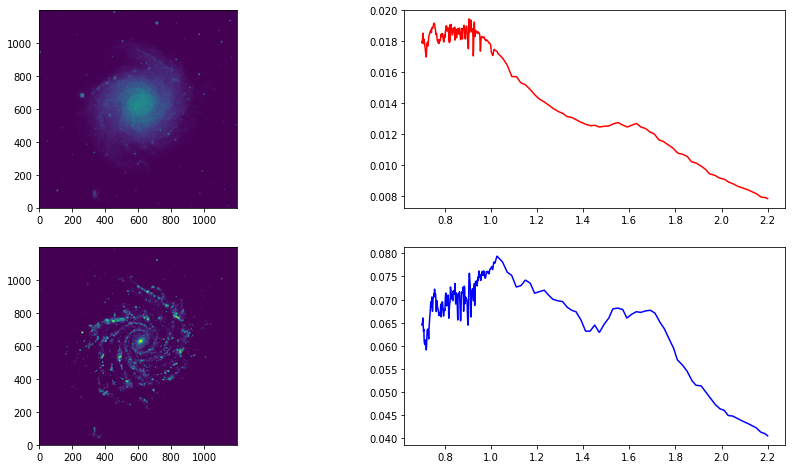

In [8]:
wave = np.linspace(0.7, 2.2, 1001) * u.um

plt.figure(figsize=(15,8))
for i, c in zip([0, 1], "rb"):
    plt.subplot(2,2,2*i+1)
    plt.imshow(gal.fields[i].data, origin="lower")
    plt.subplot(2,2,2*i+2)
    plt.plot(wave, gal.spectra[i](wave), c=c)

We can visualise approximately what portion of the galaxy that we want to come through the slit.

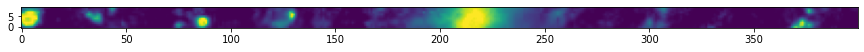

In [9]:
plt.figure(figsize=(15,3))
plt.imshow(gal.fields[1].data[625:635, 400:800], origin="lower")

# Set up MICADO in SPEC mode

Now we follow the standard proceedure to set up the ``MICADO`` optical system using a ``UserCommands`` object.
Before we initialise the optical model, we need to set a few parameters.

- ``!DET.height``: [pixel] in this context will given the number of spectral bins. As the spectral resolution changes with wavelength, it doesn't make sense to specify a desired wavelength region. Instead the user can choose more or fewer spectral bins on the detector. For the sake of speed we will restrict this simulation to 1000 spectral bins.
- ``!OBS.filter_name_fw1``: MICADO has two filter wheels. To view which filters are on which wheels, use ``micado["filter_wheel_2"].filters``
- ``!OBS.dit``: [s] the exposure time

In [ ]:
cmd = sim.UserCommands(use_instrument="MICADO", set_modes=["SCAO", "SPEC"])
cmd["!DET.height"] = 1000
cmd["!OBS.filter_name_fw1"] = "Spec_HK"
cmd["!OBS.filter_name_fw2"] = "open"
cmd["!OBS.dit"] = 3600
cmd["!INST.psf.strehl"]= 0.2

In the ``MICADO`` package the slit aperture size and position can be set freely. 
The default values correspond to the short-fat slit (3000x50mas) centred on the field of view apnning the x-axis.

In [ ]:
cmd["!INST.aperture.x"] = 0             # [arcsec]
cmd["!INST.aperture.y"] = 0
cmd["!INST.aperture.width"] = 3         # [arcsec]
cmd["!INST.aperture.height"] = 0.05    

As always, the standard process for creating an optical model, observing, and reading out the detector window:

In [ ]:
micado = sim.OpticalTrain(cmd)
micado.observe(gal)
hdus = micado.readout()

The figure below shows the detector window readout in spectroscopy mode.
It's clear that the spectrum from the new population dominates.
It is now up to the user to decide which regions of the spectrum need to be extracted for analysis.
Below we show a very rudimentary way to extract 1D spectra from the image.

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(hdus[0][1].data)
plt.colorbar()
plt.ylabel("Wavelength")
plt.xlabel("Slit position")

The above image doesn't tell us anything about the wavelength range we're covering, just as the raw MICADO detector readouts will not tell us anything about the observed spectrum. 

We can however extract the wavelength calibration from the MICADO ``OpticalTrain`` object by looking at how many spectral slices (FOV objects) were generated. This requires a bit Python Kung-Fu. Rest assured that this will be easier in later releases of ScopeSim.

In [ ]:
waves = [fov.wavelength.value for fov in micado.fov_manager._fovs_list]
flux = hdus[0][1].data[10:, 400:410].sum(axis=1)

plt.figure(figsize=(15, 5))
plt.plot(waves[9:], flux)